# Separable JSA for photon triplets

# Ideal case for waveguides

## Conditions: phase-matching, group-velocity matching, $\beta_F\gg\beta_P$

### Minimal working example

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
from matplotlib.ticker import FormatStrFormatter

**Phase-mismatch Taylor expansion**

$$
\frac{\ell}{2} \Delta k\left(\delta\omega_1,\delta\omega_2,\delta\omega_3\right)=\tau_1 \left(\delta\omega_1+\delta\omega_2+\delta\omega_3\right)+\tau_P^2\left(\delta\omega_1+\delta\omega_2+\delta\omega_3\right)^2-\tau_F^2\left(\delta\omega_1^2+\delta\omega_2^2+\delta\omega_3^2\right),$$

where 

$$\tau_1=\frac{L}{2}\left(\frac{1}{v_{g_{P}}}-\frac{1}{v_{g_{F}}}\right),~\tau_P^2=\frac{L}{4}\beta_{2_P},~\tau_F^2=\frac{L}{4}\beta_{2_F}.$$

**Phase-mismatch expansion in scaled units**

Defining scaled frequencies $w_1,~w_2,~w_3~=~\tau_F~\delta\omega_1,~\tau_F~\delta\omega_2,~\tau_F~\delta\omega_3$, we have

$$\frac{\ell}{2} \Delta k\left(w_1,~w_2,~w_3\right)=\frac{\tau_1}{\tau_F} \left(w_1+~w_2+~w_3\right)+\frac{\tau_P^2}{\tau_F^2}\left(w_1+~w_2+~w_3\right)^2-\left(w_1^2+w_2^2+w_3^2\right),$$

**Pump envelope function in scaled units**

Defining a gaussian pump:

$$\alpha \left(\delta\omega_1,\delta\omega_2,\delta\omega_3\right)= \exp \left(-\frac{1}{2}T^2\left(\delta\omega_1+\delta\omega_2+\delta\omega_3\right)^2\right)$$

We can now write it in scaled units as

$$\alpha \left(w_1,~w_2,~w_3\right)= \exp \left(-\frac{1}{2}\frac{T^2}{\tau_F^2}\left(w_1+w_2+w_3\right)^2\right)$$

In [2]:
#Wavevector expansion: Phase mismatch calculation
def ldelk(tau1, taup,tauf,w1,w2,w3): 
    ldelk=(tau1/tauf)*(w1+w2+w3)+((taup**2)/(tauf**2))*(w1*w2+w2*w3+w1*w3)+(w1**2+w2**2+w3**2)
    return ldelk

In [3]:
#JSA-Using the Taylor expansion of the wavevector
def JSAD(tau1, taup,tauf,w1,w2,w3,T0):
    jsad=jnp.sinc((1/(jnp.pi))*(ldelk(tau1, taup,tauf,w1,w2,w3)))*jnp.exp(-(1/2)*(T0**2/tauf**2)*((w1+w2+w3))**2)
    return jsad

### Experiment: Pump bandwidth sweep

In [4]:
#Conditions
tau11=0  # Group-velocity matching
taup1=0  # \beta_P << \beta_F -->\beta_P negligible in comparison to \beta_F
tauf1=1  # \beta_F >> \beta_P
sigmapm0=jnp.sqrt(jnp.pi)/tauf1 # Approximate HWHM of the phase-matching function, measured in terms of the sinc's main lobe width

jnpts=100
sigma_vec=jnp.linspace(1e-24,10*sigmapm0,jnpts)
T01=1/sigma_vec # Matching the phase-matching bandwidth

In [5]:
# Spectral resolution
delw=sigmapm0/30 # The spectral resolution is defined such that a minimum of 30 discrete points are sampled within each frequency vector over the bandwidth of the phase-matching function, regardless of the specific width of the evaluation function.

#Spectral window
domg=10*sigmapm0 # We set the half-width of the frequency window wide enough to sample correctly both the jsa and reduced density matrix
omf=jnp.arange(-domg,domg,delw)
print(omf.size) # Note: Always check the frequency vector size, because later we are going to build a 3D grid with it, which greatly affects  the memory usage. 

600


In [6]:
purevec=np.zeros_like(sigma_vec)
for i,t in enumerate(T01):
    JSA_3D=JSAD(tau11,taup1,tauf1,omf[:,None,None],omf[None,:,None],omf[None,None,:],t) 
    rho_aD=jnp.einsum('ijk,ljk->il',JSA_3D,jnp.conj(JSA_3D))
    U,S,Vh=jnp.linalg.svd(rho_aD,full_matrices=True, hermitian=True)
    purevec[i]=jnp.sum(S)**2/jnp.sum(S**2)
    print(i,purevec[i])
    del JSA_3D,rho_aD,U,S,Vh

0 nan
1 5.187968717346277
2 2.7350380017597358
3 1.9732150628262464
4 1.632606112692926
5 1.4583376998163327
6 1.363712764805325
7 1.3108114997422358
8 1.2808945338845854
9 1.2641370036347563
10 1.2551840611663605
11 1.251008551015171
12 1.2498345222305909
13 1.2505822856619728
14 1.2525739771768296
15 1.2553720097792624
16 1.258687254111284
17 1.2623250260785
18 1.2661522827974727
19 1.2700771142799525
20 1.274035586392194
21 1.2779831042588257
22 1.2818886269313254
23 1.2857307220647751
24 1.2894948326160223
25 1.2931713567366292
26 1.2967542823644727
27 1.3002402058506695
28 1.3036276200432462
29 1.3069163937209756
30 1.3101073883888288
31 1.3132021746416684
32 1.31620282133182
33 1.3191117383855608
34 1.3219315594261478
35 1.3246650541118974
36 1.3273150627725951
37 1.329884447853648
38 1.3323760580757344
39 1.3347927022419888
40 1.3371371303797575
41 1.3394120204648488
42 1.3416199693952364
43 1.3437634871963011
44 1.3458449936773829
45 1.3478668169404746
46 1.3498311932794016
47 

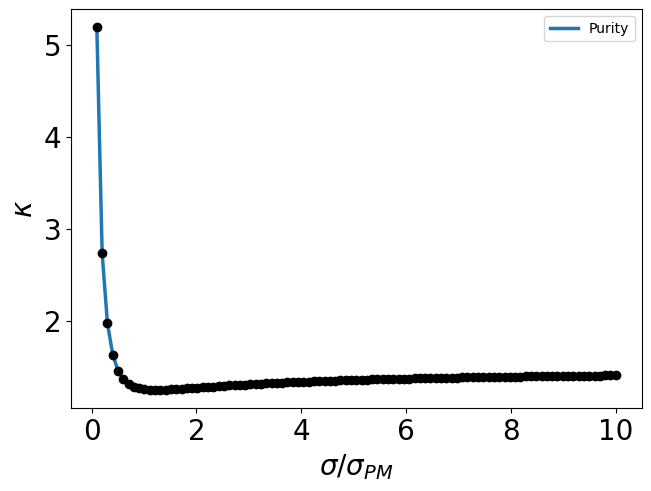

In [7]:
font={'size':20}
plt.rc('font',**font)

fig1, axs1 = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)


plt.plot(sigma_vec/sigmapm0,purevec,label='Purity',linewidth=2.5)
plt.plot(sigma_vec/sigmapm0,purevec,'ko',linewidth=2.5)
plt.xlabel(r'$\sigma/\sigma_{PM}$') 
plt.ylabel(r"$\kappa$") 
# plt.xlim(omf[0]/jnp.sqrt(jnp.pi),omf[-1]/jnp.sqrt(jnp.pi))
  
plt.legend(prop={'size':10})

# plt.savefig("Figures_export/Weighted_modes_ideal.pdf", format="pdf", bbox_inches="tight")
plt.show()

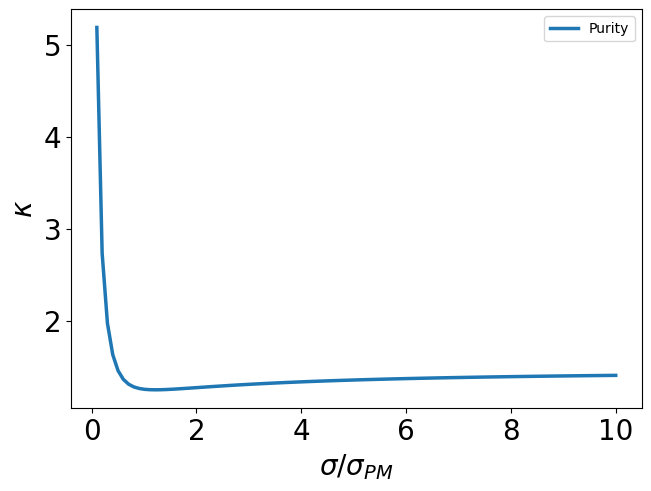

In [8]:
font={'size':20}
plt.rc('font',**font)

fig2, axs2 = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)


plt.plot(sigma_vec/sigmapm0,purevec,label='Purity',linewidth=2.5)
plt.xlabel(r'$\sigma/\sigma_{PM}$') 
plt.ylabel(r"$\kappa$") 
# plt.xlim(omf[0]/jnp.sqrt(jnp.pi),omf[-1]/jnp.sqrt(jnp.pi))
  
plt.legend(prop={'size':10})

# plt.savefig("Figures_export/Weighted_modes_ideal.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Data export

In [9]:
puredict={
    "tag":"Ideal case- Optimal pump bandwidth",
    "sigma":sigma_vec,
    "purity":purevec
}
savemat("Data_export/Ideal_case_pump_bandwidth_sweep.mat",puredict)


In [11]:
sig=(1/(4*np.pi))*sigmapm0
tsig=1/sig
JSA_3D=JSAD(tau11,taup1,tauf1,omf[:,None,None],omf[None,:,None],omf[None,None,:],tsig) 
rho_aD=jnp.einsum('ijk,ljk->il',JSA_3D,jnp.conj(JSA_3D))
U,S,Vh=jnp.linalg.svd(rho_aD,full_matrices=True, hermitian=True)
pure=jnp.sum(S)**2/jnp.sum(S**2)
print(pure)

6.5381556848937565
